In [1]:
import sys
colab = 'google.colab' in sys.modules

if colab:
    root_dir = "/content/"
else:
    root_dir = ""

import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"{device=}")

device=device(type='cuda')


In [11]:
# !pip install kaggle intervaltree
# !mkdir -p ~/.kaggle
# !echo '{"username":"talkogan","key":"80d03fec7ab514205af1708902cd9778"}' > ~/.kaggle/kaggle.json
# !chmod 600 ~/.kaggle/kaggle.json
# !if [ ! -f musicnet-dataset.zip ]; then kaggle datasets download -d imsparsh/musicnet-dataset; unzip musicnet-dataset.zip > /dev/null; fi

In [2]:
import pandas as pd
import numpy as np

meta = pd.read_csv(f"{root_dir}musicnet_metadata.csv")
ids = np.array(meta["id"])
np.random.shuffle(ids)

# 80-20 Train-Test Split
threshold = int(0.8 * len(ids))
train_ids = ids[:threshold]
test_ids = ids[threshold:]

In [5]:
# Load the data from the musicnet.npz file
musicnet = np.load('musicnet.npz', allow_pickle=True, encoding='latin1')

In [6]:
bpm_bins = np.arange(44, 300, 1)

def bin_to_bpm_range(bin_index):
    if bin_index < 0 or bin_index > len(bpm_bins) - 1:
        raise ValueError(f"Bin index {bin_index=} out of range")
    if bin_index == len(bpm_bins) - 1:
        return bpm_bins[bin_index], 300
    return bpm_bins[bin_index], bpm_bins[bin_index + 1]

In [7]:
import numpy as np
import pandas as pd
import librosa

def preprocess_data(musicnet_data, wav_id, sample_rate=44100, n_mels=40, n_frames=256, bpm_bins=bpm_bins):
    audio, _ = musicnet_data[wav_id]

    # Try to load labels from train, if failed then it's probably from the test
    try:
        labels = pd.read_csv(f"{root_dir}musicnet/musicnet/train_labels/{wav_id}.csv")
    except FileNotFoundError:
        labels = pd.read_csv(f"{root_dir}musicnet/musicnet/test_labels/{wav_id}.csv")

    # Number of frames per segment in the mel spectrogram
    hop_length = 2048  # Hop length to match 11.9 seconds to 256 frames

    # Convert the audio data to a mel spectrogram
    mel_spec = librosa.feature.melspectrogram(y=audio, sr=sample_rate, hop_length=hop_length, n_mels=n_mels, fmin=20, fmax=5000)
    mel_spec = librosa.power_to_db(mel_spec, ref=np.max)

    # Spectrogram scaling on the time axis with a random factor
    scaling_factor = np.random.choice(np.arange(0.8, 1.21, 0.04))
    mel_spec = librosa.util.fix_length(mel_spec, size=int(mel_spec.shape[1] * scaling_factor))

    segment_samples = n_frames * hop_length
    segment_frames = n_frames

    segments = []
    bpm_classes = []

    # Split the audio and mel spectrogram into segments
    for start in range(0, len(audio), segment_samples):
        end = start + segment_samples
        audio_segment = audio[start:end]
        mel_segment = mel_spec[:, start // hop_length:end // hop_length]

        if len(audio_segment) != segment_samples:
            break

        if mel_segment.shape[1] < segment_frames:
            padding = segment_frames - mel_segment.shape[1]
            mel_segment = np.pad(mel_segment, ((0, 0), (0, padding)), mode='constant')
        elif mel_segment.shape[1] > segment_frames:
            mel_segment = mel_segment[:, :segment_frames]

        segments.append(mel_segment.astype(np.float32).T)

        # Adjust the labels for the current segment
        label_segment = labels[(labels['start_time'] >= start) & (labels['end_time'] < end)].copy()
        label_segment.loc[:, 'start_time'] -= start
        label_segment.loc[:, 'end_time'] -= start

        # Calculate BPM class for each segment
        tempo, _ = librosa.beat.beat_track(y=audio_segment, sr=sample_rate)
        if isinstance(tempo, float):
            bpm = tempo
        else:
            bpm = tempo[0]
        bpm_class = np.digitize(bpm, bpm_bins) - 1

        # onset_times = label_segment.loc[:, 'start_time'].values
        # onset_times -= onset_times[0]
        # onset_times = onset_times / 1000
        # print(onset_times)
        # onset_env = np.zeros(n_frames)
        # for onset in onset_times:
        #     frame = int(onset * sample_rate / hop_length)
        #     if frame < n_frames:
        #         onset_env[frame] = 1

        # print(f"{onset_env=}")
        # tempo_from_onset, _ = librosa.beat.beat_track(onset_envelope=onset_env, sr=sample_rate)
        # if isinstance(tempo_from_onset, float):
        #     bpm_from_onset = tempo_from_onset
        # else:
        #     bpm_from_onset = tempo_from_onset[0]

        # print(f"{bpm=} {bpm_from_onset=}")

        # Create a one-hot vector for the BPM class
        one_hot_vector = np.zeros(len(bpm_bins))
        one_hot_vector[bpm_class] = 1
        bpm_classes.append(one_hot_vector)

    return segments, bpm_classes


In [8]:
import random

random_id = random.choice(train_ids)
print(f"Random ID: {random_id}")

mel_specs, bpms = preprocess_data(musicnet, wav_id=str(random_id))
print(f"Number of segments: {len(mel_specs)}")
print(f"BPM Class: {bin_to_bpm_range(np.argmax(bpms[0]))}")
print(f"Segment shape: {mel_specs[0].shape}")
print(f"BPM Class shape: {bpms[0].shape}")

Random ID: 2567
Number of segments: 32
BPM Class: (112, 113)
Segment shape: (256, 40)
BPM Class shape: (256,)


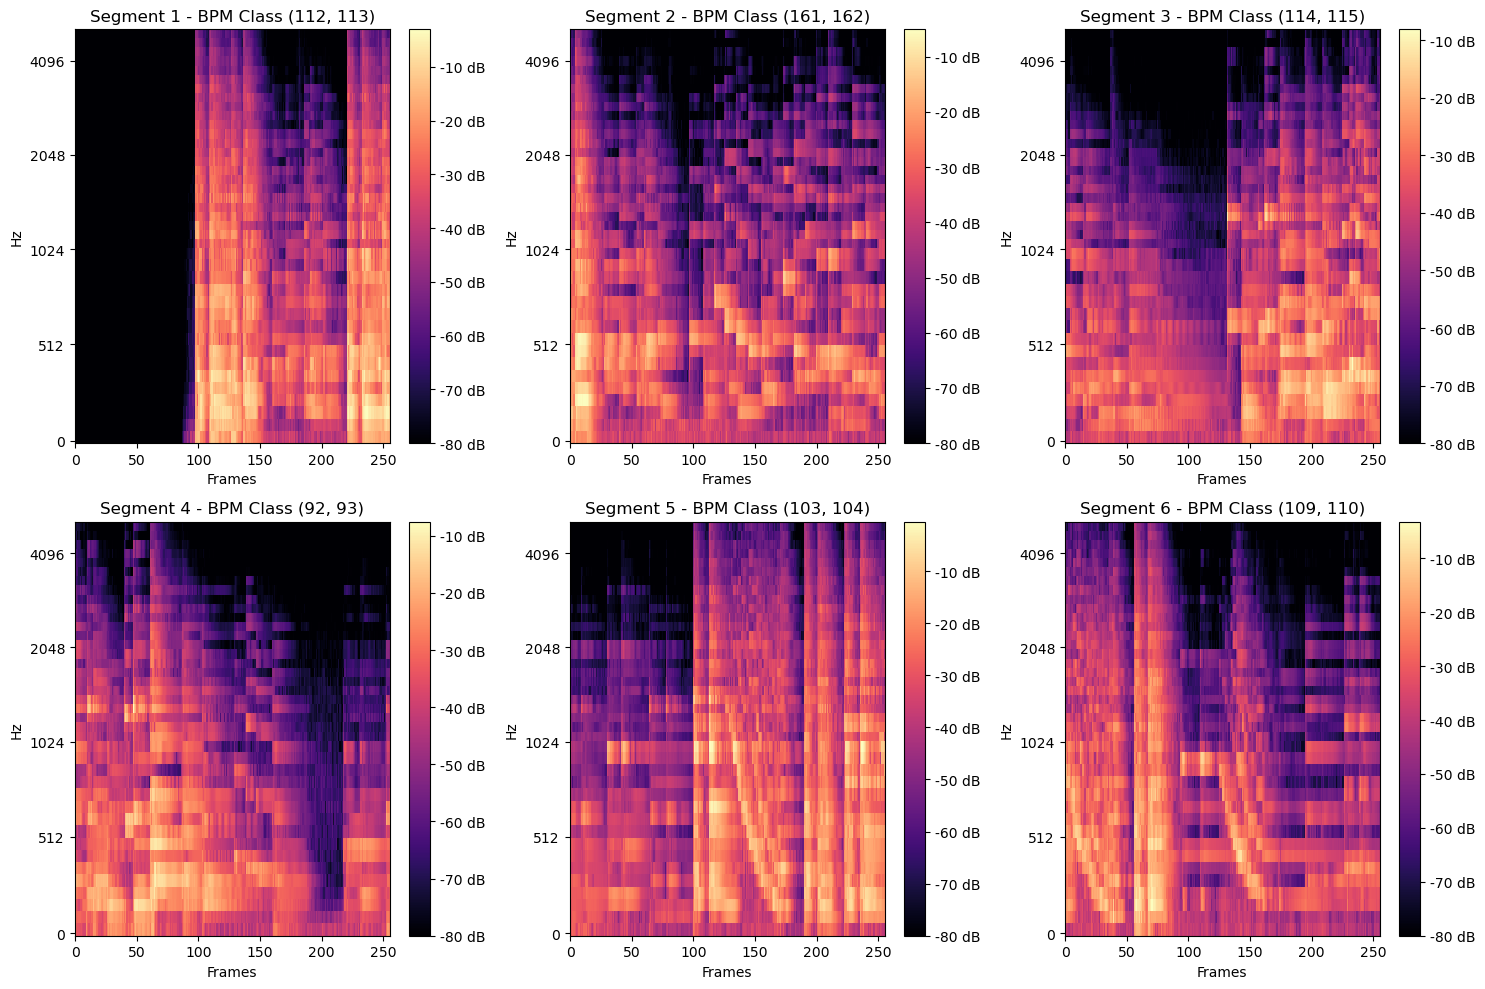

In [9]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
for i, ax in enumerate(axes.flatten()):
    if i < len(mel_specs):
        mel_spec = mel_specs[i]
        img = librosa.display.specshow(mel_spec.T, sr=44100, hop_length=2048, fmin=20, fmax=5000, x_axis='frames', y_axis='mel', ax=ax)
        ax.set_title(f'Segment {i+1} - BPM Class {bin_to_bpm_range(np.argmax(bpms[i]))}')
        fig.colorbar(img, ax=ax, format='%+2.0f dB')

plt.tight_layout()
plt.show()


In [ ]:
# !pip install tqdm

In [174]:
# Lists to hold train and test data
train_segments = []
train_bpm_classes = []
test_segments = []
test_bpm_classes = []

from tqdm.notebook import tqdm

# Preprocess train data
for i, wav_id in enumerate(tqdm(train_ids, desc="Preprocessing Train Data", unit="file")):
    segments, bpm_classes = preprocess_data(musicnet, str(wav_id))
    train_segments.extend(segments)
    train_bpm_classes.extend(bpm_classes)

train_segments = np.array(train_segments)
train_bpm_classes = np.array(train_bpm_classes)
np.savez('train_data.npz', segments=train_segments, bpm_classes=train_bpm_classes)

# Preprocess test data
for i, wav_id in enumerate(tqdm(test_ids, desc="Preprocessing Test Data", unit="file")):
    segments, bpm_classes = preprocess_data(musicnet, str(wav_id))
    test_segments.extend(segments)
    test_bpm_classes.extend(bpm_classes)

test_segments = np.array(test_segments)
test_bpm_classes = np.array(test_bpm_classes)
np.savez('test_data.npz', segments=test_segments, bpm_classes=test_bpm_classes)

Preprocessing Train Data:   0%|          | 0/264 [00:00<?, ?file/s]

Preprocessing Test Data:   0%|          | 0/66 [00:00<?, ?file/s]

In [21]:
with np.load('train_data.npz', allow_pickle=True) as train_data:
    train_segments, train_bpm_classes = train_data['segments'], train_data['bpm_classes']

with np.load('test_data.npz', allow_pickle=True) as test_data:
    test_segments, test_bpm_classes = test_data['segments'], test_data['bpm_classes']


In [30]:
# The original model from the paper:
# Music Tempo Estimation via Neural Networks – A comparative Analysis
import torch
import torch.nn as nn

class BRNNModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, rnn_num_layers, output_dim):
        super(BRNNModel, self).__init__()

        self.bn = nn.BatchNorm1d(input_dim)
        self.rnn_i2h = nn.RNN(input_dim,      hidden_dim, rnn_num_layers, bidirectional=True, batch_first=True, nonlinearity='tanh')
        self.rnn_h2h = nn.RNN(2 * hidden_dim, 2 * hidden_dim, rnn_num_layers, bidirectional=True, batch_first=True, nonlinearity='tanh')
        self.rnn_h2d = nn.RNN(4 * hidden_dim, 4 * hidden_dim, rnn_num_layers, bidirectional=True, batch_first=True, nonlinearity='tanh')

        self.avg_pool = nn.AvgPool1d(kernel_size=5)
        self.batch_norm_fc = nn.BatchNorm1d(8 * hidden_dim)

        self.dense_layer = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(8 * hidden_dim, 128),
            nn.ELU(),
            nn.BatchNorm1d(128),
            nn.Linear(128, 128),
            nn.ELU(),
            nn.BatchNorm1d(128),
        )

        self.output_layer = nn.Linear(128, output_dim)

        self.init_weights()

    def init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                # torch.nn.init.xavier_normal_(m.weight, gain=1.0)
                torch.nn.init.kaiming_normal_(m.weight, a=0, mode='fan_in', nonlinearity='leaky_relu')
                if m.bias is not None:
                    torch.nn.init.constant_(m.bias, 0)

    def forward(self, x):
        batch_size, seq_len, _ = x.size()
        x = x.view(batch_size * seq_len, -1)  # Flatten the input for batch norm
        x = self.bn(x)
        x = x.view(batch_size, seq_len, -1)  # Reshape back to (batch_size, seq_len, input_size)

        x, _ = self.rnn_i2h(x)
        x, _ = self.rnn_h2h(x)
        x, _ = self.rnn_h2d(x)

        # x = x.permute(0, 2, 1)  # Swap dimensions for AvgPool1d
        # x = self.avg_pool(x)
        # x = x.permute(0, 2, 1)  # Swap dimensions back

        batch_size, seq_len, _ = x.size()
        x = x.reshape(batch_size * seq_len, -1)  # Flatten for batch norm
        x = self.batch_norm_fc(x)
        x = x.reshape(batch_size, seq_len, -1)  # Reshape back to (batch_size, seq_len, hidden_size*2)

        x = x[:, -1, :]  # Take the last time step output

        x = self.dense_layer(x)
        x = self.output_layer(x)

        return x

input_dim = 40
hidden_dim = 25
rnn_num_layers = 5
output_dim = 256

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = BRNNModel(input_dim, hidden_dim, rnn_num_layers, output_dim).to(device)

batch_size = 32
sequence_length = 256

x = torch.randn(batch_size, sequence_length, input_dim).to(device)
print(x.shape)
output = model(x)
print(output.shape)


torch.Size([32, 256, 40])
torch.Size([32, 256])


In [31]:
# Untrained!
x = torch.tensor(mel_specs).to(device)
print(x.shape)

model = BRNNModel(input_dim, hidden_dim, rnn_num_layers, output_dim).to(device)
output = model(x)

torch.Size([32, 256, 40])


In [29]:
import torch
import torch.nn as nn

class BLSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, lstm_num_layers, output_dim):
        super(BLSTMModel, self).__init__()

        self.bn = nn.BatchNorm1d(input_dim)
        self.lstm_i2h = nn.LSTM(input_dim,      hidden_dim, lstm_num_layers, bidirectional=True, batch_first=True)
        self.lstm_h2h = nn.LSTM(2 * hidden_dim, 2 * hidden_dim, lstm_num_layers, bidirectional=True, batch_first=True)
        self.lstm_h2d = nn.LSTM(4 * hidden_dim, 4 * hidden_dim, lstm_num_layers, bidirectional=True, batch_first=True)

        self.avg_pool = nn.AvgPool1d(kernel_size=5)
        self.batch_norm_fc = nn.BatchNorm1d(8 * hidden_dim)

        self.dense_layer = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(8 * hidden_dim, 128),
            nn.ELU(),
            nn.BatchNorm1d(128),
            nn.Linear(128, 128),
            nn.ELU(),
            nn.BatchNorm1d(128),
        )

        self.output_layer = nn.Linear(128, output_dim)


    def forward(self, x):
        batch_size, seq_len, _ = x.size()
        x = x.view(batch_size * seq_len, -1)  # Flatten the input for batch norm
        x = self.bn(x)
        x = x.view(batch_size, seq_len, -1)  # Reshape back to (batch_size, seq_len, input_size)

        x, _ = self.lstm_i2h(x)
        x, _ = self.lstm_h2h(x)
        x, _ = self.lstm_h2d(x)

        x = x.permute(0, 2, 1)  # Swap dimensions for AvgPool1d
        x = self.avg_pool(x)
        x = x.permute(0, 2, 1)  # Swap dimensions back

        batch_size, seq_len, _ = x.size()
        x = x.reshape(batch_size * seq_len, -1)  # Flatten for batch norm
        x = self.batch_norm_fc(x)
        x = x.reshape(batch_size, seq_len, -1)  # Reshape back to (batch_size, seq_len, hidden_size*2)

        x = x[:, -1, :]  # Take the last time step output

        x = self.dense_layer(x)
        x = self.output_layer(x)

        return x

input_dim = 40
hidden_dim = 25
rnn_num_layers = 1
output_dim = 256

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = BLSTMModel(input_dim, hidden_dim, rnn_num_layers, output_dim).to(device)

batch_size = 32
sequence_length = 256

x = torch.randn(batch_size, sequence_length, input_dim).to(device)
output = model(x)
print(output.shape)

torch.Size([32, 256])


In [206]:
# Untrained!
x = torch.tensor(mel_specs).to(device)
print(x.shape)

model = BLSTMModel(input_dim, hidden_dim, rnn_num_layers, output_dim).to(device)
output = model(x)

torch.Size([25, 256, 40])
batch_size=25 seq_len=256


In [12]:
import time
from torch.optim.lr_scheduler import MultiStepLR

def calculate_accuracy(model, dataloader, device):
    model.eval()
    total_correct = 0
    total_labels = 0

    with torch.no_grad():
        for data in dataloader:
            mels, labels = data
            mels = mels.to(device)
            labels = labels.to(device)
            outputs = model(mels)
            # y_pred = outputs.squeeze(0).argmax(0)
            _, y_pred = torch.max(outputs.data, 1)
            _, y_true = torch.max(labels.data, 1)
            total_labels += labels.size(0)
            total_correct += (y_pred == y_true).sum().item()

    model_accuracy = total_correct / total_labels * 100
    return model_accuracy


def train_model(model, train_dataloader, test_dataloader, device, num_epochs=500):
    learning_rate = 1e-4
    clip_value = 5

    # momentum = 0.9
    # optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum)
    optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

    criterion = nn.CrossEntropyLoss()
    scheduler = MultiStepLR(optimizer, milestones=[100, 200, 300, 400], gamma=0.1)

    # Train the model
    train_losses = []
    train_accuracies = []
    for epoch in range(1, num_epochs + 1):
        model.train()
        running_loss = 0.0
        epoch_time = time.time()

        for i, (data, labels) in enumerate(train_dataloader):
            # Move data to the device
            data = data.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model(data)

            # Calculate the loss
            loss = criterion(outputs, labels)

            # Backpropagate and update the weights
            optimizer.zero_grad()
            loss.backward()

            # Gradient clipping
            torch.nn.utils.clip_grad_norm_(model.parameters(), clip_value)

            optimizer.step()

            running_loss += loss.item()

        running_loss /= len(train_dataloader)
        train_accuracy = calculate_accuracy(model, train_dataloader, device)
        test_accuracy = calculate_accuracy(model, test_dataloader, device)

        print(f'Epoch [{epoch:2}/{num_epochs}] | Loss: {running_loss:.4f} | Training Accuracy: {train_accuracy:.4f}% | Test Accuracy: {test_accuracy:.4f}% | Time: {time.time() - epoch_time}')

        train_losses.append(running_loss)
        train_accuracies.append(train_accuracy)

        scheduler.step()

    # Evaluate the model on the test set
    test_accuracy = calculate_accuracy(model, test_dataloader, device)

    print(f'{type(model).__name__} Model: Accuracy: {test_accuracy:.4f}%')
    return train_losses, train_accuracies


In [32]:
from torch.utils.data import TensorDataset, DataLoader

batch_size = 8

# Create train and test datasets
train_dataset = TensorDataset(torch.tensor(train_segments), torch.tensor(train_bpm_classes))
test_dataset = TensorDataset(torch.tensor(test_segments), torch.tensor(test_bpm_classes))

# Create train and test dataloaders
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

# Train the models
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"{device=}")

brnn_model = BRNNModel(input_dim, hidden_dim, rnn_num_layers, output_dim).to(device)
print(brnn_model)

# b_lstm_model = BLSTMModel(input_dim, hidden_dim, rnn_num_layers, output_dim).to(device)
# print(b_lstm_model)

device=device(type='cuda')
BRNNModel(
  (bn): BatchNorm1d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (rnn_i2h): RNN(40, 25, num_layers=5, batch_first=True, bidirectional=True)
  (rnn_h2h): RNN(50, 50, num_layers=5, batch_first=True, bidirectional=True)
  (rnn_h2d): RNN(100, 100, num_layers=5, batch_first=True, bidirectional=True)
  (avg_pool): AvgPool1d(kernel_size=(5,), stride=(5,), padding=(0,))
  (batch_norm_fc): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dense_layer): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=200, out_features=128, bias=True)
    (2): ELU(alpha=1.0)
    (3): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): Linear(in_features=128, out_features=128, bias=True)
    (5): ELU(alpha=1.0)
    (6): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (output_layer): Linear(in_features=128, out_fe

In [33]:
brnn_acc = train_model(brnn_model, train_dataloader, test_dataloader, device, 100)

Epoch [ 1/100] | Loss: 6.2318 | Training Accuracy: 1.9794% | Test Accuracy: 2.2888% | Time: 44.223217725753784
Epoch [ 2/100] | Loss: 5.7730 | Training Accuracy: 1.9674% | Test Accuracy: 2.2888% | Time: 44.358317852020264


KeyboardInterrupt: 

In [182]:
lstm_acc = train_model(b_lstm_model, train_dataloader, test_dataloader, device)

Epoch [ 1/500] | Loss: 5.0969 | Training Accuracy: 3.9347% | Test Accuracy: 2.0708% | Time: 4.58896279335022
Epoch [ 2/500] | Loss: 4.0984 | Training Accuracy: 4.3906% | Test Accuracy: 3.1608% | Time: 5.041041612625122
Epoch [ 3/500] | Loss: 4.0046 | Training Accuracy: 4.5945% | Test Accuracy: 2.6703% | Time: 5.886014938354492
Epoch [ 4/500] | Loss: 3.9813 | Training Accuracy: 5.2183% | Test Accuracy: 2.5068% | Time: 5.583878040313721
Epoch [ 5/500] | Loss: 3.9659 | Training Accuracy: 4.8105% | Test Accuracy: 3.8692% | Time: 5.410407304763794
Epoch [ 6/500] | Loss: 3.9628 | Training Accuracy: 4.6545% | Test Accuracy: 3.2153% | Time: 5.545722484588623
Epoch [ 7/500] | Loss: 3.9480 | Training Accuracy: 5.6022% | Test Accuracy: 3.2698% | Time: 5.358015060424805
Epoch [ 8/500] | Loss: 3.9378 | Training Accuracy: 5.1703% | Test Accuracy: 2.5613% | Time: 5.527508974075317
Epoch [ 9/500] | Loss: 3.9344 | Training Accuracy: 5.1823% | Test Accuracy: 3.3787% | Time: 5.3461503982543945
Epoch [10/

KeyboardInterrupt: 

In [ ]:

import numpy as np
import matplotlib.pyplot as plt

plt.title('Model Accuracy')
plt.ylabel('Accuracy (%)')
plt.xlabel('Epoch')
plt.xticks(np.arange(1, 501, 100))
plt.ylim(0, 100)

n_epochs = len(brnn_acc[1])

plt.plot(range(1, n_epochs + 1), brnn_acc[1], label='BRNN')
plt.plot(range(1, n_epochs + 1), lstm_acc[1], label='BLSTM')

plt.legend(loc='lower right')
plt.show()
